In [742]:
# Time spent on assignment: 12 hours

import numdifftools as nd
import numpy as np
import matplotlib as mpl
np.set_printoptions(precision=3, suppress=True)
%load_ext autoreload
%autoreload 2
# %matplotlib inline
# %config InlineBackend.print_figure_kwargs = {'bbox_inches':None}

from deriv_utils import compute_jacobian, derivative_in_direction
from plotter import plot_vector_field
from vector import TangentVector, VectorBases, GroupTangentVector


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


2. Make a function for generating the derivative in the direction of a function at a given point.
Deliverables:
- Replicate the Cartesian-expressed polar vector fields in Fig. 2.7 and Example 2.3.1 using your direction-derivative code.
- Demonstrate that you can equivalently create the vector fields by using the numerical Jacobian of a function F to map a single generating vector out to points on the field.

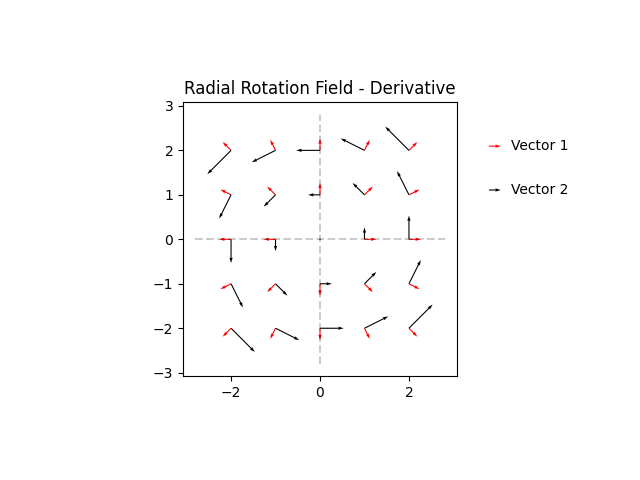

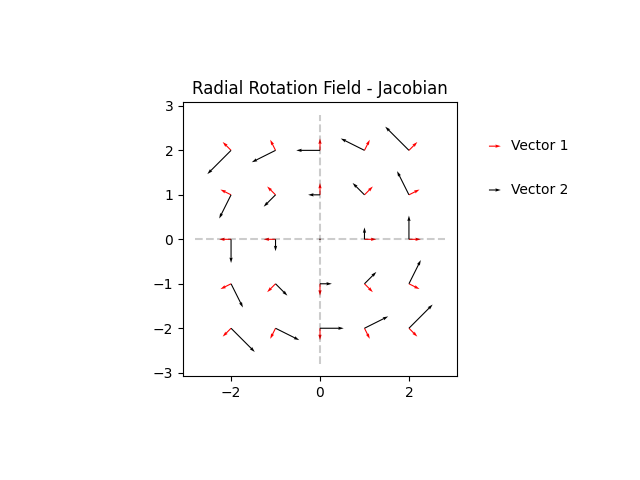

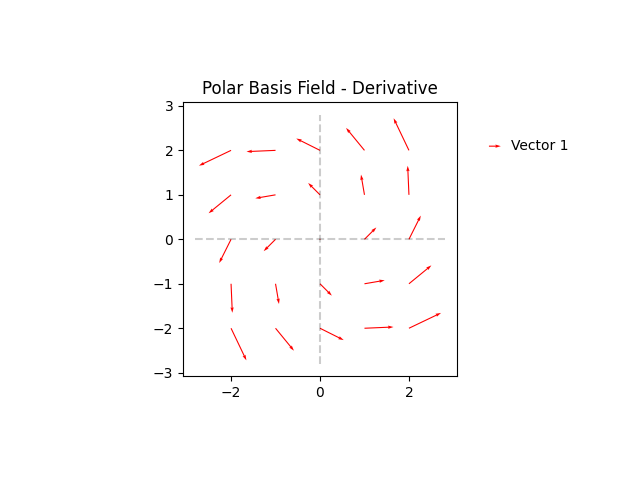

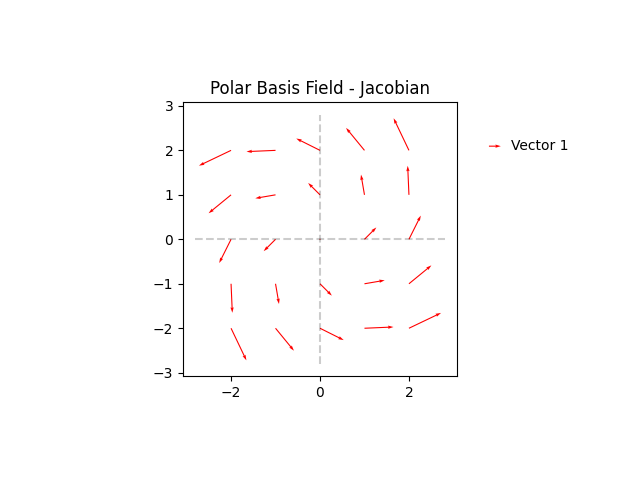

In [743]:
def radial(config, delta = 0):
    x, y = config
    r = np.sqrt(x**2 + y**2)
    if isinstance(delta,np.ndarray):
        delta = delta.flatten()[0]
    rho = float(delta)
    # eq 2.49
    radial_factor = (1. + rho / r) if not np.isclose(r, 0.) else 1
    polar = radial_factor * config.reshape(2,1)
    return polar.reshape(config.shape)

def rotation(config, delta = 0):
    if isinstance(delta,np.ndarray):
        delta = delta.flatten()[0]
    phi = float(delta)
    # eq 2.48
    rotation_factor = np.array([[np.cos(phi), -np.sin(phi)], [np.sin(phi), np.cos(phi)]])
    polar = rotation_factor @ config.reshape(2,1)
    return polar

def radial_rotation(config, delta = 0):
    if isinstance(delta,np.ndarray):
        delta = delta.flatten()[0]
    phi_rho = delta * np.array([1., 1.]).reshape(2, 1)
    x, y = config
    # eq 2.52
    r = np.sqrt(x**2 + y**2)
    rinv = 1 / r if not np.isclose(r, 0.) else 1
    diff_rho = np.array([x * rinv, y * rinv]).reshape(2, 1)
    diff_phi = np.array([-y, x]).reshape(2, 1)
    radial_rotation = np.hstack([diff_phi, diff_rho]) @ phi_rho
    return radial_rotation.reshape(config.shape)

x = y = np.linspace(-2, 2, 5)
X, Y = np.meshgrid(x, y)
configuration = np.vstack((X.ravel(), Y.ravel())).T
radial_derivs = [derivative_in_direction(radial, config.reshape(2,)) for config in configuration]
rotation_derivs = [derivative_in_direction(rotation, config.reshape(2,)) for config in configuration]
vb = VectorBases(radial_derivs)
vb2 = VectorBases(rotation_derivs)
plot_vector_field(vb.configs().T, [vb.flatten().T, vb2.flatten().T], title="Radial Rotation Field - Derivative")

radial_jacob = np.stack([compute_jacobian(radial, config.reshape(2,)) for config in configuration])
rotation_jacob = np.stack([compute_jacobian(rotation, config.reshape(2,)) for config in configuration])
vb = VectorBases(radial_jacob)
vb2 = VectorBases(rotation_jacob)
plot_vector_field(vb.configs().T, [vb.flatten().T, vb2.flatten().T], title="Radial Rotation Field - Jacobian")

radial_rotation_derivs = [derivative_in_direction(radial_rotation, config.reshape(2,)) for config in configuration]
vb = VectorBases(radial_rotation_derivs)
plot_vector_field(vb.configs().T, [vb.flatten().T], title="Polar Basis Field - Derivative")

radial_rotation_jacob = np.stack([compute_jacobian(radial_rotation, config.reshape(2,)) for config in configuration])
vb = VectorBases(radial_rotation_jacob)
plot_vector_field(vb.configs().T, [vb.flatten().T], title="Polar Basis Field - Jacobian")

3. Make a “group tangent vector” class that stores the location of the vector as a group element instead of a simple list of coordinate values


Deliverables: Replicate the groupwise vector basis fields in Fig. 2.10 b and c, using your direction-derivative function with the group actions of elements that are δ away from the identity in single components.

deriv: [[ 0.5 -1. ]
 [ 0.   0. ]] at config RepGroupElement(value=[ 0.5 -1. ], group=SemiDirectProduct)
deriv: [[ 1. -1.]
 [ 0.  0.]] at config RepGroupElement(value=[ 1. -1.], group=SemiDirectProduct)
deriv: [[ 1.5 -1. ]
 [ 0.   0. ]] at config RepGroupElement(value=[ 1.5 -1. ], group=SemiDirectProduct)
deriv: [[ 2. -1.]
 [ 0.  0.]] at config RepGroupElement(value=[ 2. -1.], group=SemiDirectProduct)
deriv: [[ 0.5 -0.5]
 [ 0.   0. ]] at config RepGroupElement(value=[ 0.5 -0.5], group=SemiDirectProduct)
deriv: [[ 1.  -0.5]
 [ 0.   0. ]] at config RepGroupElement(value=[ 1.  -0.5], group=SemiDirectProduct)
deriv: [[ 1.5 -0.5]
 [ 0.   0. ]] at config RepGroupElement(value=[ 1.5 -0.5], group=SemiDirectProduct)
deriv: [[ 2.  -0.5]
 [ 0.   0. ]] at config RepGroupElement(value=[ 2.  -0.5], group=SemiDirectProduct)
deriv: [[0.5 0. ]
 [0.  0. ]] at config RepGroupElement(value=[0.5 0. ], group=SemiDirectProduct)
deriv: [[1. 0.]
 [0. 0.]] at config RepGroupElement(value=[1. 0.], group=SemiDirec

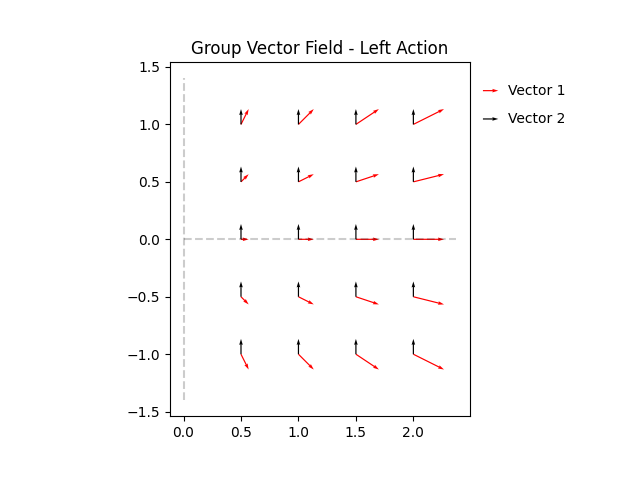

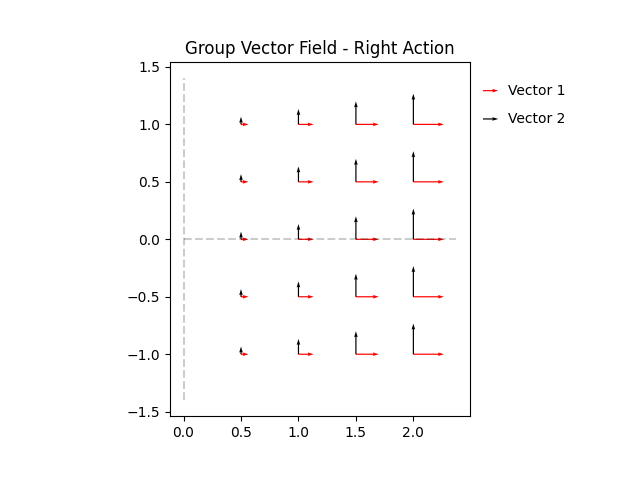

In [744]:
from repgroup import SemiDirectProduct, RepGroupElement

def sdp_g1_left_action(delta, config: RepGroupElement) -> np.ndarray:
    if isinstance(delta, np.ndarray):
        delta = delta.flatten()[0]
    # gdelta1 compose config is config in t + delta
    direction = RepGroupElement(value = np.array([1 + delta, 0]), group=config.group)
    return direction.left_action(config).value

def sdp_g2_left_action(delta, config: RepGroupElement) -> np.ndarray:
    if isinstance(delta, np.ndarray):
        delta = delta.flatten()[0]
    direction = RepGroupElement(value = np.array([0, delta]), group=config.group)
    return direction.left_action(config).value

def sdp_g1_right_action(delta, config: RepGroupElement) -> np.ndarray:
    if isinstance(delta, np.ndarray):
        delta = delta.flatten()[0]
    direction = RepGroupElement(value = np.array([1 + delta, 0]), group=config.group)
    return direction.right_action(config).value

def sdp_g2_right_action(delta, config: RepGroupElement) -> np.ndarray:
    if isinstance(delta, np.ndarray):
        delta = delta.flatten()[0]
    direction = RepGroupElement(value = np.array([0, delta]), group=config.group)
    return direction.right_action(config).value

def derivative_group_action(func, config: RepGroupElement) -> np.ndarray:
    reduced_group_action = lambda delta: func(delta, config)
    deriv = nd.Derivative(reduced_group_action)(0.)
    print(f'deriv: {deriv} at config {config}')
    return GroupTangentVector(val=RepGroupElement(value=deriv, group=config.group), config=config)

class GroupVectorBases(object):
    def __init__(self, vectors: list) -> None:
        self.vectors = vectors

    @property
    def elements(self):
        return self.vectors

    def __repr__(self) -> str:
        return f'GroupVectorBases(vectors: {self.vectors})'

    def evaluate(self, func):
        group_tangent_bases = [derivative_group_action(func, config=vector) for vector in self.vectors]
        return VectorBases([gtv.as_tv() for gtv in group_tangent_bases], inverse=group_tangent_bases[0].group.identity)

    # def __call__(self, elem, action="left"):
    #     return self.evaluate(elem, action)

x = np.linspace(0.5, 2, 4)
y = np.linspace(-1, 1, 5)
X, Y = np.meshgrid(x, y)
configuration = np.vstack((X.ravel(), Y.ravel())).T
sdp = SemiDirectProduct()
group_vectors = [RepGroupElement(value=config, group=sdp) for config in configuration]
group_vb = GroupVectorBases(group_vectors)
res_g1 = group_vb.evaluate(sdp_g1_left_action)
res_g2 = group_vb.evaluate(sdp_g2_left_action)
plot_vector_field(res_g1.configs().T, [res_g1.flatten().T, res_g2.flatten().T], title="Group Vector Field - Left Action")
res_g1 = group_vb.evaluate(sdp_g1_right_action)
res_g2 = group_vb.evaluate(sdp_g2_right_action)
plot_vector_field(res_g1.configs().T, [res_g1.flatten().T, res_g2.flatten().T], title="Group Vector Field - Right Action")





(20, 2)
[[ 0.5  1.   1.5  2.   0.5  1.   1.5  2.   0.5  1.   1.5  2.   0.5  1.
   1.5  2.   0.5  1.   1.5  2. ]
 [-1.  -1.  -1.  -1.  -0.5 -0.5 -0.5 -0.5  0.   0.   0.   0.   0.5  0.5
   0.5  0.5  1.   1.   1.   1. ]]
[[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]]


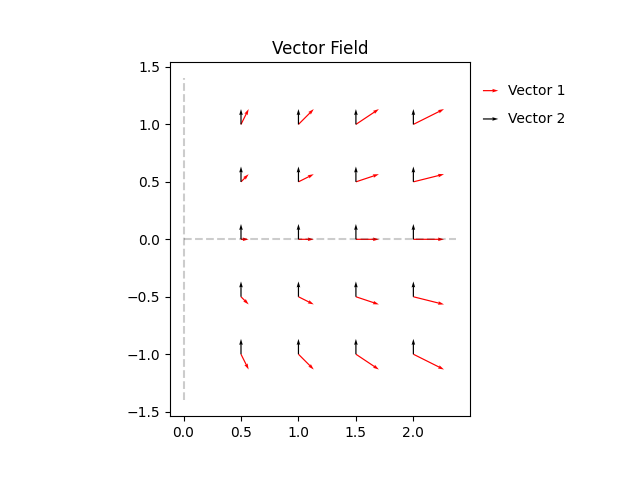

Extend your group element class so that it has left and right lifted actions that act on vectors.
These lifted actions should be generated automatically from the group action using numerical differentiation tools, and their outputs should return group tangent vectors anchored at the new location. Also provide an adjoint action (named Ad) on vectors, which combines the left
and right lifted actions.
Deliverables:
 - Replicate the groupwise vector basis fields in Fig. 2.10 b and c, using lifted actions to
transfer unit-coefficient vectors at the identity out to each point.
 - Find the scale-shift vector adjoint to g = [1 1/2].T at g = ( 1/2, −1), and make a set of plots similar to Fig. 2 11 demonstrating this adjoint relationship